In [6]:
import os
import numpy as np

import torch

from src.utils import get_transform, collate_fn, Custom_Dataset, Evaluator
from src.plotting import show_prediction
from src.saving import Model_Manager
from src.deployable_network import Deployable_Network

## Testing Deployable Network

To test how the network could be deployed in real time on a moving belt, some experimentation was done with a Deployable_Network. In this section of the notebook, bounding box ensembling techniques may be tested. These include non-maximum supression and weighted bounding box fusion. Provide the location and model filename to (`file_location` and `model_filename`) to load the trained object detector - if no `version` is assigned, the latest will be loaded.

Class prioritisation should be implimented in the case where the two classes are similar in edge cases, leading to the model making ambiguous predictions, such as the image shown bellow where multiple predictions are made for one object. `similar_classes` holds a list of tuples , each of which corresponding to a given prioritisation. For instance, to prioritise class 1 over class 3, add the tuple `(1,3)` to this list.

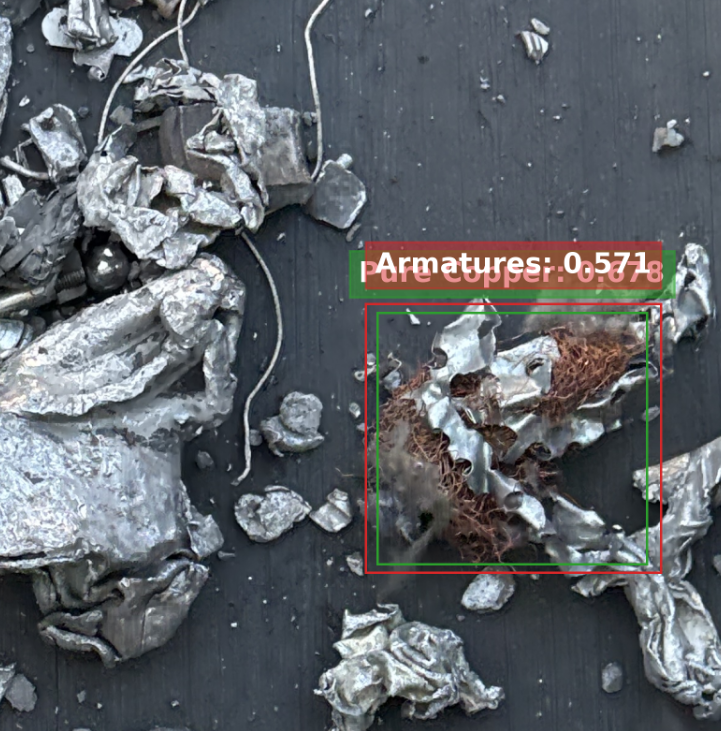

In [11]:
#Detector + classifier location
file_location = 'path/to/models'
model_filename = 'Model Name'
path = os.path.join(file_location, model_filename)

#Load the model and (if requested) any annotations
model_manager = Model_Manager(path)
give_annotations = True
version = 1
if give_annotations:
    object_detector, annotations_paths = model_manager.load(version=version, give_annotations=give_annotations)
else:
    object_detector = model_manager.load(version=version, give_annotations=give_annotations)

#Similar classes for fine classifier
similar_classes = [(1,3), (2,3)]     #Class 1 is prioritised over class 3 and class 2 is prioritised over class 3

#Initialise fine detector
model = Deployable_Network(object_detector, similar_classes)

#Send model to device
device = torch.device('cpu')
model.to(device)

Model loaded from /Users/benmarrett/Documents/EMR/Model Implimentation/Saved Models/Faster RCNN All Classes/v_1


DeployableNetwork(
  (ObjectDetector): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, 

To test the precision of this deployable model, it is helpful to test on images it has not trained on. If train/test subsets were saved during training, `give_annotations` should be set to true in the cell above and the train/test annotations will be loaded. These contain image paths and annotation data for the ground truths (boxes, scores and labels), along with the categories used. The cell bellow produces a dataloader using only the test dataset, so the deployable model may be evaluated on images its base object detector has not yet seen.

In [ ]:
#Download dataset
#annotations_path = '/Users/benmarrett/Documents/EMR/Model Implimentation/Faster R-CNN/formatted_annotations.json'
dataset = Custom_Dataset(annotations_paths[0], get_transform(train=False))

train_percent = 1.     #Percentage of data for training
final_train_ind = int(len(dataset) * train_percent)
indices = torch.randperm(len(dataset)).tolist()        #Randomise train + test images

dataset = torch.utils.data.Subset(dataset, indices[:final_train_ind])   #Convert to subset so that evaluator works

#Convert to dataloaders
batch_size = 1
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

The cell bellow simply compares the base object detector to the deployable model. Give the `path` to the target image and the cell shows predictions from both the base object detector and the full deployable model.

/Users/benmarrett/Documents/EMR/Images/Real Belt/Hard Belt - No Monolayer (iPhone)/IMG_5990 Large.jpeg
Speed : 1499.5ms inference, 0.0ms plotting
Speed : 1465.2ms inference, 0.0ms plotting


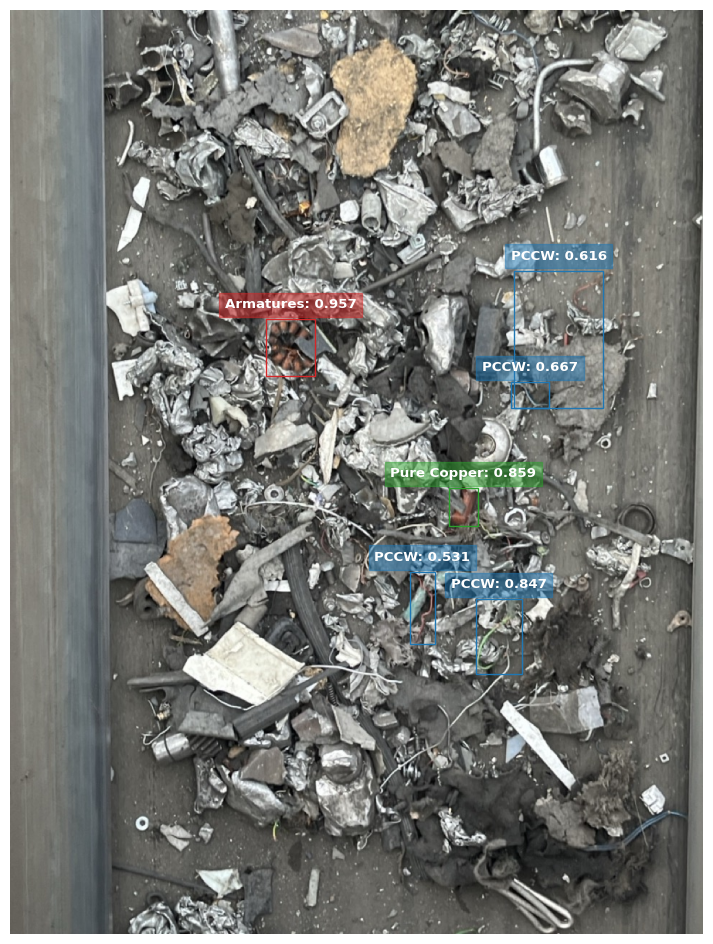

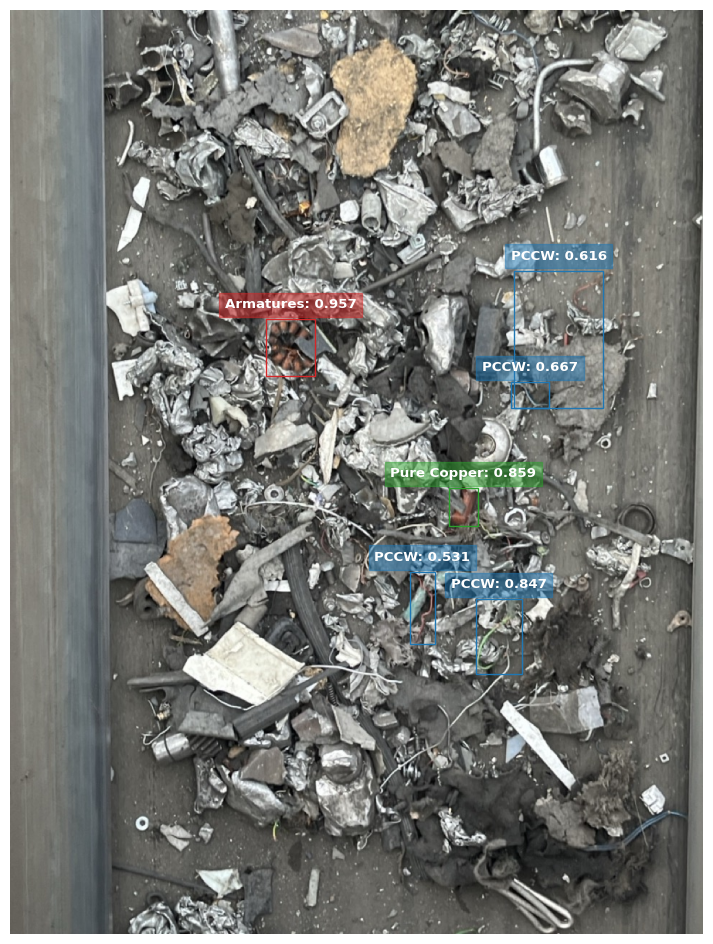

In [31]:
#Category names for labelling image
categories = {category['id'] : category['name'] for category in dataset.dataset.annotations['categories']}

#Path to image
path = 'path/to/image.jpg'

#Show predictions from base object detector and deployable model
show_prediction(object_detector, categories, path, figsize=(12,12))
show_prediction(model, categories, path, figsize=(12,12))

In [16]:
#Evaluate the deployable_model and show confusion matrix
evaluator = Evaluator(data_loader)
evaluator.evaluate(model)
evaluator.confusion_matrix()

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\admbmarrett\\Documents\\Datasets/Armatures + Frag\\images/ef5683de-IMG_5782_Large.jpeg'

## Live Inference

The was also a little experimentation with performing live inference on a moving belt. Begin by giving the deployable model information such as the camera field of view (`camera_fov`), the height of the camera above the belt (`camera_height`), the belt speed (`belt_speed`) and direction the belt is moving with respect to the image (`belt_direction`). Using this information, at each inference the deployable model translates any previous predictions across the image using the belt velocity, giving the predicted object's location where it would be at the next stage of inference. If the object is still within the frame, it may be predicted again at the current stage of inference, and so the deployable model will combine such predictions using weighted bounding box fusion. If any predictions out of the frame, their bounding box coordinates are outputted to be ejected from the feed.

In [ ]:
def calc_fov(sensor_width, focal_length):
    '''Calculates the camera field of view'''

    return 2 * np.arctan(sensor_width / (2*focal_length))

#Camera dimensions (meters)
sensor_width = 5.88e-3
focal_length = 4.25e-3
camera_height = 1      #Height above picking belt

#Calculate camera field of view
camera_fov = calc_fov(sensor_width, focal_length)

In [9]:
image_dimension = (1080,1920)  #Dimension of image from deployed camera. Must be consistent
belt_speed = 0.6               #Belt speed given in meters per second
belt_direction = 'up'          #Direction of moving belt

#Initialise model parameters usinh 
model.init_live_inference(image_dimension, camera_fov, camera_height, belt_speed, belt_direction)

run = True

while run:
    #Path to new image
    new_path = 'path/to/new/image.jpg'

    #Perform inference
    show_prediction(model, categories, new_path, figsize=(12,12))

    #Get bboxes for objects out of frame for ejection
    eject_boxes = model.return_boxes

    #Ask whether to quit live inference
    user_input = input("Continue testing? [y/N]")
    if user_input == 'N':
        print("Exiting loop")
        run = False

Exiting loop
